Ce notebook peut être exécuté en ligne avec le binder : [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fds-courses%2Foptimal-filtering-sicom/master?urlpath=lab/tree/notebooks%2F5_Kalman/N8_kalman_suivi_fusee.ipynb)

# Suivi de la trajectoire d'une fusée au décollage par filtrage de Kalman

On considère une fusée au décollage qui s'élève verticalement. Le moteur contrôle l'accélération qui est constante, mais corrompue par un bruit gaussien (variations de poussée du moteur et perturbations sur la fusée) :
$
 a(t) = a_{\textrm{moteur}} + \epsilon_{\textrm{moteur}}(t), 
$
avec $\epsilon_{\textrm{moteur}}(t)$  est un bruit blanc centré de variance $\sigma^2_{\textrm{moteur}}$.


En notant $\Delta t$ le pas d'acquisition (supposé petit), les équations de la mécanique donnent :

\begin{align*}
  z[k+1]&= z[k] + \dot{z}[k] \Delta t + a(t) \Delta t^2/ 2,\\
  \dot{z}[k+1]&= \dot{z}[k] + a(t) \Delta t,
\end{align*}


On observe l'altitude de la fusée grâce à une mesure laser (très bruitée)
\begin{align*}
 y[k] & = z[k] + \epsilon_{\textrm{laser}}[k],
\end{align*}
où  $\epsilon_{\textrm{laser}}[k]$ est un bruit blanc centré de variance $\sigma^2_{\textrm{laser}}$.

*La cellule ci-dessous est un préambule afin de charger les modules utiles*

In [12]:
import matplotlib.pyplot as plt  #  Afficher des graphiques
import numpy as np  # Représentation des tableaux par ndarray

# afficher des figures dans le notebook
# utiliser 'widget' au lieu de 'inline' pour un affichage interactif
%matplotlib inline

In [13]:
# Define Meta-variables
duration = 6  # Duration of movement (s)
dt = 0.1  # Sampling period (s)

# Initialize the random generator
seed = 2
rng = np.random.default_rng(seed=seed)

## Comment obtenir la mise en équation d'état à partir des équations précédentes ?

La forme générale de l'équation d'état est
$$
\boldsymbol{X}(k+1) = A(k) \boldsymbol{X}(k) +  B(k) \boldsymbol{U}(k) +  G(k) \boldsymbol{W}(k),
$$
où
- $\boldsymbol{X} \in \mathbb{R}^n$ est le vecteur d'état qui caractérise le système (la tarjectoire de la fusée ici) 
- $\boldsymbol{U} \in \mathbb{R}^q$ est le vecteur de commande,
- $\boldsymbol{W} \in \mathbb{R}^p$ est le vecteur de bruit du système (bruit de modélisation) de matrice de covariance $Q$

D'après les équations précédentes, l'équation d'état devient 
\begin{align*}
  \boldsymbol{X}(k+1) &= A \boldsymbol{X}(k) +  B a_{\textrm{moteur}} +  G \epsilon_{\textrm{moteur}}(t),
\end{align*}

avec 
$\boldsymbol{X}(k)\equiv \begin{pmatrix} z[k] \\ \dot{z}[k]\end{pmatrix} \in \mathbb{R}^2$, $\quad$
 $A\equiv\begin{pmatrix}
          1 & \Delta t \\ 0 & 1
         \end{pmatrix}$, $\quad$
         $B=G\equiv\begin{pmatrix}
          \Delta t^2/2 \\ \Delta t
         \end{pmatrix}$,   $\quad$
         $Q\equiv \sigma^2_{\textrm{moteur}}$.


In [14]:
# State transition matrix
# State prediction
A = np.array([[1, dt], [0, 1]])

# Input control matrix
# Expected effect of the input acceleration on the state
B = np.array([[0.5 * dt ** 2], [dt]])

## Comment obtenir l'équation d'observation à partir du vecteur d'état ?


L'équation d'observation $\boldsymbol{Y}(k) = C(k) \boldsymbol{X}(k) + \boldsymbol{V}(k)$ devient

\begin{align*}
  y[k] &=  \begin{pmatrix} 1 & 0 \end{pmatrix} \begin{pmatrix} z[k] \\ \dot{z}[k] \end{pmatrix} + \epsilon_{\textrm{laser}}[k],
\end{align*}
i.e. 
$\boldsymbol{Y}(k)= y[k]\in \mathbb{R}$, $\quad$
$C(k)=\begin{pmatrix} 1 & 0 \end{pmatrix}$, $\quad$
$\boldsymbol{V}(k) = \epsilon_{\textrm{laser}}[k]$, $\quad$ 
$R(k)\equiv \textrm{cov}(\boldsymbol{V}(k)) = \sigma^2_{\textrm{laser}}$

D'après les hypothèses, les séries de bruits d'état  $\boldsymbol{W}(k) \equiv \epsilon_{\textrm{moteur}}[k]$ et de mesure $\boldsymbol{V}(k) \equiv \epsilon_{\textrm{laser}}[k]$ sont bien  blanches et conjointement indépendantes.

In [15]:
# Measurement matrix
# The expected measurement given the predicted state
C = np.array([[1, 0]])

## Définition des variables du problème

In [16]:
# Acceleration magnitute (m.s^{-2})
u_t = 5

# State process noise
# Standard deviation of process (acceleration in this case (m.s^{-2}))
u_t_noise_sd = 5

# Measurement Noise
# Standard deviation of measurement (position in this case (m))
y_t_noise_sd = 10

# Covariance matrices for noise
# Convert stdv into covariance noise by squaring it
# State (process) covariance
E_x = u_t_noise_sd ** 2 * np.array([[dt ** 4 / 4, dt ** 3 / 2], [dt ** 3 / 2, dt ** 2]])

#  Measurement covariance
E_y = np.array([[y_t_noise_sd ** 2]])

## Simulation de la série temporelle des mesures

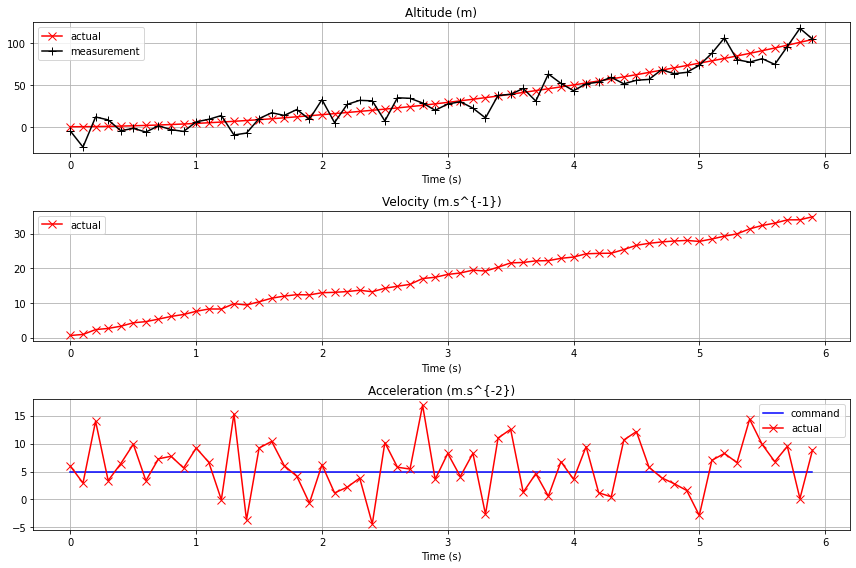

In [17]:
# Initial Sate
# Two components: [position; velocity]
x_t = np.array([[0], [0]])

# Initialize Result Variables
z_actual = []  # Actual path
v_actual = []  # Actual velocity
a_actual = []  # Actual acceleration
z_measure = []  # Measured path

time_axis = np.arange(0, duration, dt)

# Generate the path and the observations
for t in time_axis:

    # Acceleration Noise
    acc_add_noise = u_t_noise_sd * rng.normal()
    ex = acc_add_noise * B

    # State Prediction
    x_t = A @ x_t + B * u_t + ex

    # Measurement Noise
    ey = y_t_noise_sd * rng.normal()
    # Observation
    y_t = C @ x_t + ey

    # Store for plotting
    z_actual.append(x_t[0])
    z_measure.append(y_t.item())
    v_actual.append(x_t[1])
    a_actual.append(u_t + acc_add_noise)

plt.subplots(3, 1, figsize=(12, 8), sharex=True)
marker_style = dict(markersize=8, fillstyle="none")
plt.subplot(311)
plt.plot(time_axis, z_actual, "-rx", label="actual", **marker_style)
plt.plot(time_axis, z_measure, "-k+", label="measurement", **marker_style)
plt.grid("on")
plt.legend()
plt.title("Altitude (m)")
plt.xlabel("Time (s)")

plt.subplot(312)
plt.plot(time_axis, v_actual, "-rx", label="actual", **marker_style)
plt.grid("on")
plt.legend()
plt.title("Velocity (m.s^{-1})")
plt.xlabel("Time (s)")

plt.subplot(313)
plt.plot(time_axis, u_t * np.ones(time_axis.shape), "-b", label="command")
plt.plot(time_axis, a_actual, "-rx", label="actual", **marker_style)
plt.grid("on")
plt.legend()
plt.title("Acceleration (m.s^{-2})")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

## Filtrage de Kalman afin d'estimer l'état (position, vitesse) de la fusée

In [22]:
# Initialize the estimation variables

# Estimate of the first component of the state (position)
z_hat = [0]
z_hat = [-10]
# Estimate of the second component of the state (velocity)
v_hat = [0]
v_hat = [10]
# Estimate of the initial state x
x_hat_t = np.array([z_hat, v_hat])
# Estimate of initial state variance
E_hat_t = 1e+10 * E_x
# Store the position variances for each estimate t
z_hat_sd = [E_hat_t[0, 0]]

#  Set the prior covariances

# Model noise covariance
fact_x = 1  #  factor between the prior covariance and the actual one
#fact_x = 100
u_t_noise_sd_kalman = fact_x * u_t_noise_sd
E_x = u_t_noise_sd_kalman ** 2 * np.array(
    [[dt ** 4 / 4, dt ** 3 / 2], [dt ** 3 / 2, dt ** 2]]
)

# Measurement noise
fact_y = 1  # factor between the prior covariance and the actual one
#fact_y = 100
y_t_noise_sd_kalman = fact_y * y_t_noise_sd
E_y = np.array([[y_t_noise_sd_kalman ** 2]])

for k, t in enumerate(time_axis[:-1]):

    ## Update step

    # Kalman gain
    K_t = E_hat_t @ C.T @ np.linalg.pinv(C @ E_hat_t @ C.T + E_y)
    # Update the state estimate
    x_hat_t = x_hat_t + K_t @ (z_measure[k+1] - C @ x_hat_t)
    # Update the covariance of the estimate
    P = np.eye(2) - K_t @ C
    E_hat_t = P @ E_hat_t @ P.T + K_t @ E_y @ K_t.T  # Joseph form

    ## Prediction step

    #  Predict the next state
    x_hat_t = A @ x_hat_t + B * u_t
    # Predict the next covariance
    E_hat_t = A @ E_hat_t @ A.T + E_x

    #  Store for plotting
    z_hat.append(x_hat_t[0, 0])
    v_hat.append(x_hat_t[1, 0])
    z_hat_sd.append(E_hat_t[0, 0])

Plot the results

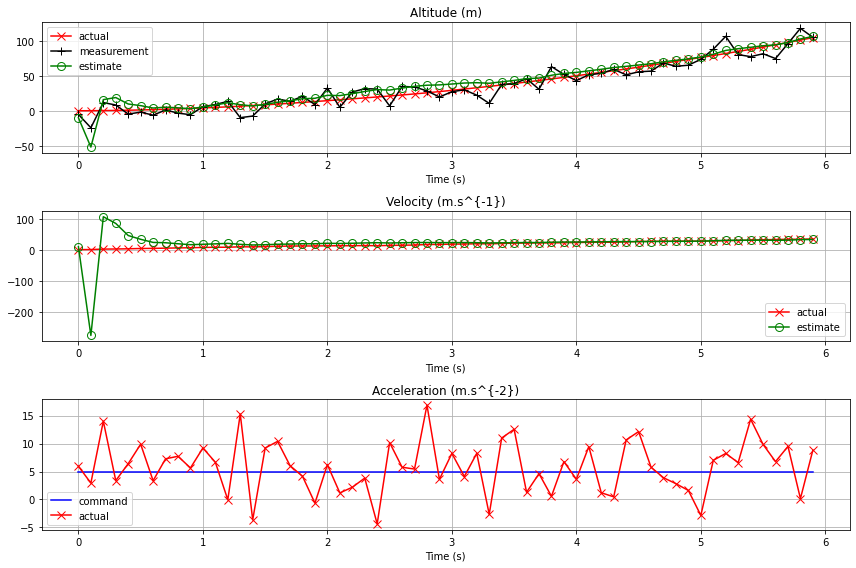

In [23]:
plt.subplots(3, 1, figsize=(12, 8), sharex=True)
marker_style = dict(markersize=8, fillstyle="none")

plt.subplot(311)
plt.plot(time_axis, z_actual, "-rx", label="actual", **marker_style)
plt.plot(time_axis, z_measure, "-k+", label="measurement", **marker_style)
plt.plot(time_axis, z_hat, "-go", label="estimate", **marker_style)
plt.grid("on")
plt.legend()
plt.title("Altitude (m)")
plt.xlabel("Time (s)")

plt.subplot(312)
plt.plot(time_axis, v_actual, "-rx", label="actual", **marker_style)
plt.plot(time_axis, v_hat, "-go", label="estimate", **marker_style)
plt.grid("on")
plt.legend()
plt.title("Velocity (m.s^{-1})")
plt.xlabel("Time (s)")

plt.subplot(313)
plt.plot(time_axis, u_t * np.ones(time_axis.shape), "-b", label="command")
plt.plot(time_axis, a_actual, "-rx", label="actual", **marker_style)
plt.grid("on")
plt.legend()
plt.title("Acceleration (m.s^{-2})")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

**Questions :**

1. Le filtre de Kalman sempble t'il sur cet exemple améliorer la qualité d'estimation de la position de la fusée par rapport aux observations laser ?
2. Observez et expliquer le comportement du filtre si dans la représentation d'état du filtre, on prend
  - $\sigma_{\textrm{moteur}} \gg \sigma_{\textrm{laser}}$ (voir le paramètre `fact_x` dans le code) afin de traduire un doute dans le modèle et la confiance dans la mesure
  - $\sigma_{\textrm{moteur}} \ll \sigma_{\textrm{laser}}$ (voir le paramètre `fact_y` dans le code) afin de traduire un doute dans la mesure et la confiance dans la modèle
3. Observez et expliquer le comportement du filtre si l'initialisation :
  - du vecteur d'état `x_hat_t` est mauvaise ?
  - de la covariance `E_hat_t` du vecteur d'état `x_hat_t` est également mauvaise (sur ou sous estimée) ?
